In [1]:
%load_ext autoreload

In [2]:
autoreload 2

In [3]:
cd ..

/home/gcouairo/weather


In [4]:
from geoarches.lightning_modules import load_module

/home/gcouairo/miniconda3/envs/weather2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# load_module will look in modelstore/
model, config = load_module('archesweather-m-seed0')

/home/gcouairo/miniconda3/envs/weather2/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Restored from modelstore/archesweather-m-seed0/checkpoints/checkpoint.ckpt


In [6]:
# we can also load the 4-members deterministic ensemble ArchesWeather-Mx4 like so:

model, config = load_module('archesweather-m-seed0',
                  avg_with_modules=['archesweather-m-seed1',
                                    'archesweather-m-skip-seed0',
                                    'archesweather-m-skip-seed1'])

Restored from modelstore/archesweather-m-seed1/checkpoints/checkpoint.ckpt
Restored from modelstore/archesweather-m-skip-seed0/checkpoints/checkpoint.ckpt
Restored from modelstore/archesweather-m-skip-seed1/checkpoints/checkpoint.ckpt
Restored from modelstore/archesweather-m-seed0/checkpoints/checkpoint.ckpt


In [7]:
# load sample from dataloader
from geoarches.dataloaders.era5 import Era5Forecast

ds = Era5Forecast(path='data/era5_240/full', # default path
                  load_prev=True, # whether to load previous state
                  norm_scheme='pangu', # default normalization scheme
                  domain='test', # domain to consider. domain = 'test' loads the 2020 period
                 )

12it [00:00, 54.00it/s]

start time 2019-12-31T00:00:00


In [8]:
#The dataset returns a dict of TensorDict:
print('keys in a sample:', ds[0].keys())
# a state contains level and surface variables in a TensorDict, which is a specialized structure for dict of tensors
print('sample state', ds[0]['state'])

keys in a sample: dict_keys(['timestamp', 'state', 'lead_time_hours', 'next_state', 'prev_state'])
sample state TensorDict(
    fields={
        level: Tensor(shape=torch.Size([6, 13, 121, 240]), device=cpu, dtype=torch.float32, is_shared=False),
        surface: Tensor(shape=torch.Size([4, 1, 121, 240]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)


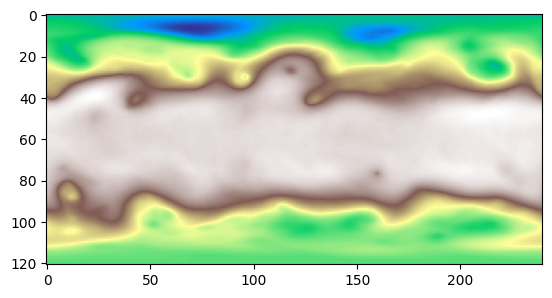

In [9]:
# we can visualize a sample, e.g. Z500, with the following

import matplotlib.pyplot as plt
plt.imshow(ds[0]['state']['level'][0, 7], cmap='terrain')

In [10]:
# now we can run inference with the deterministic model ArchesWeather:
import torch
torch.set_grad_enabled(False)

device = 'cuda:0'

model = model.to(device)

batch = {k:v[None].to(device) for k, v in ds[0].items()}

pred = model(batch).cpu()

In [11]:
# optionally, we can denormalize the prediction to go back to real physical values
pred = ds.denormalize(pred)

24h Z500 prediction


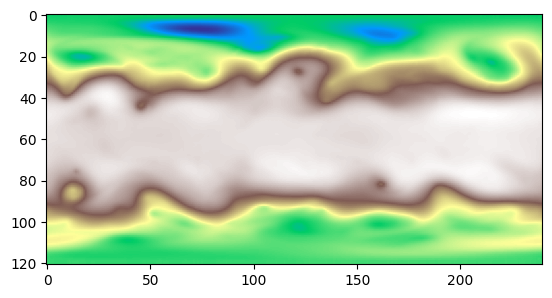

24h ground truth


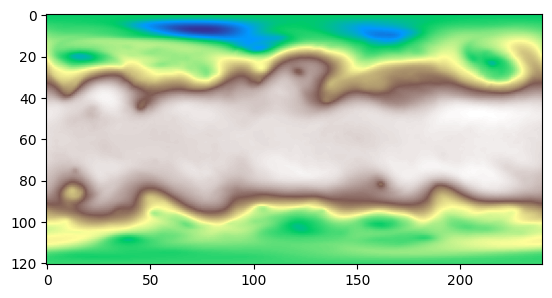

In [12]:
# we can visualize predictions, compared to 

print('24h Z500 prediction')
plt.imshow(pred['level'][0, 0, 7], cmap='terrain')
plt.show()

print('24h ground truth')
plt.imshow(ds[0]['next_state']['level'][0, 7], cmap='terrain')
plt.show()


In [13]:
# we can also do multistep rollouts with the deterministic model:
pred_multistep = model.forward_multistep(batch, iters=10) # this does a 10-day rollout
# the rollout dimension is the second dimension in the predicted tensors
pred_multistep

TensorDict(
    fields={
        level: Tensor(shape=torch.Size([1, 10, 6, 13, 121, 240]), device=cuda:0, dtype=torch.float32, is_shared=True),
        surface: Tensor(shape=torch.Size([1, 10, 4, 1, 121, 240]), device=cuda:0, dtype=torch.float32, is_shared=True)},
    batch_size=torch.Size([1, 10]),
    device=cuda:0,
    is_shared=True)

# Loading and running ArchesWeatherGen

In [ ]:
# loading ArchesWeatherFlow
device = 'cuda:0'

# load_module will look in modelstore/
gen_model, gen_config = load_module('archesweathergen')

gen_model = gen_model.to(device)

Restored from modelstore/archesweather-m-seed0/checkpoints/checkpoint.ckpt
Restored from modelstore/archesweather-m-seed1/checkpoints/checkpoint.ckpt
Restored from modelstore/archesweather-m-skip-seed0/checkpoints/checkpoint.ckpt
Restored from modelstore/archesweather-m-skip-seed1/checkpoints/checkpoint.ckpt
Restored from modelstore/archesweathergen/checkpoints/checkpoint.ckpt


In [15]:
# run model on a sample
seed = 0
num_steps = 25 # if not provided to model.sample, model will use the default value (25)
scale_input_noise = 1.05

batch = {k:v[None].to(device) for k, v in ds[0].items()}


sample = gen_model.sample(batch, 
                    seed=seed, 
                    num_steps=num_steps,
                    scale_input_noise=scale_input_noise).cpu()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.25it/s]


In [ ]:
# run a model auto-regressively 

rollout_iterations = 10
n_members = 10

sample_multistep = [model.sample_rollout(batch,
                                         batch_nb=0, # should be different for each input
                                         member=i,
                                         iterations=rollout_iterations)
                    for i in range(n_members)]